# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [86]:
# import libraries
import pickle
import re
import warnings

import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.svm import SVC
from sqlalchemy import create_engine

nltk.download(["punkt", "wordnet", "averaged_perceptron_tagger"])


warnings.simplefilter("ignore")

[nltk_data] Downloading package punkt to /home/roger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/roger/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/roger/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [87]:
# load data from database
engine = create_engine("sqlite:///disaster_response.db")
df = pd.read_sql("SELECT * FROM messages", engine)
# random sample 10% of the data. Delete this line to run analysis on full data set
# df = df.sample(frac=0.1, replace=False, random_state=1)
X = df["message"]
Y = df.drop(["id", "message", "original", "genre"], axis=1)

### 2. Write a tokenization function to process your text data

In [103]:
def tokenize(text):
    """Normalize, tokenize and stem text string
    
    Args:
    text: string. String containing message for processing
       
    Returns:
    stemmed: list of strings. List containing normalized and stemmed word tokens
    """
    # Convert text to lowercase and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

    # Tokenize words
    tokens = word_tokenize(text)

    # Stem word tokens and remove stop words
    stemmer = PorterStemmer()
    stop_words = stopwords.words("english")

    stemmed = [stemmer.stem(word) for word in tokens if word not in stop_words]

    return stemmed

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [158]:
rf_pipe = Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=tokenize)),
        ("tfidf", TfidfTransformer()),
        (
            "clf",
            MultiOutputClassifier(RandomForestClassifier(random_state=1, n_jobs=-1)),
        ),
    ]
)

### 4. Train pipeline
- Split data into train and test sets
-Train pipeline

In [138]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)
rf_pipe.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                                                                        ccp_alpha=0.0,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                   

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [140]:
# Make predictions on the training data
Y_train_pred = rf_pipe.predict(X_train)
Y_test_pred = rf_pipe.predict(X_test)

In [141]:
from sklearn.metrics import classification_report


def display_score(y_true, y_pred):
    """helper function to display the classification_report in DataFrame format
    for all categories"""
    report_dict = classification_report(
        y_true, y_pred, output_dict=True, target_names=y_true.columns
    )
    return pd.DataFrame(report_dict).T[:-3]


display_score(Y_test, Y_test_pred)

,precision,recall,f1-score,support
related,0.839423,0.948259,0.890528,4967.0
request,0.835067,0.501786,0.626882,1120.0
offer,0.000000,0.000000,0.000000,23.0
aid_related,0.743028,0.696155,0.718828,2679.0
medical_help,0.580645,0.069364,0.123924,519.0
medical_products,0.810811,0.093458,0.167598,321.0
search_and_rescue,0.444444,0.026144,0.049383,153.0
security,0.000000,0.000000,0.000000,124.0
military,0.687500,0.049327,0.092050,223.0
water,0.877551,0.413462,0.562092,416.0


- the micro average score (which calculates metrics globally by counting the total true positives, false negatives and false positives) will be used and focused on to evaluate the performance of the machine learning model.
- Certain categories have 0 value in precision, recall, and f1 scores. They correspond to the low support value. In other words, the portion of the data with value of 1 in these categories are so small and the trained model does not make any positive predictions that are true positives. (See plot below)
- We will explore other options to improve the model in the following sections of this notebook.

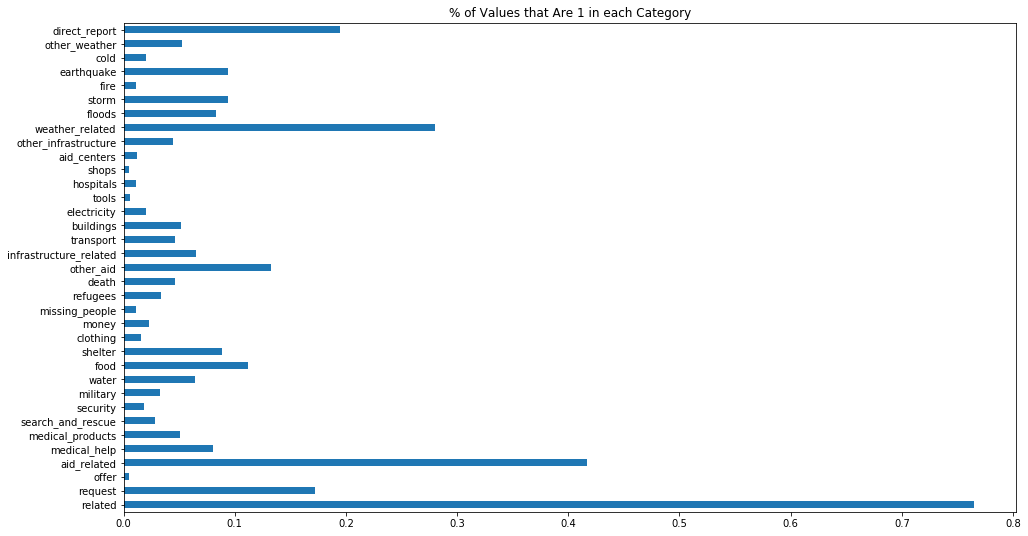

In [142]:
# porpotion of response value of 1 in each response category in the data set
cat_portion_df = Y.sum() / len(Y)
cat_portion_df.plot.barh(
    title="% of Responses that Are 1 in Each Category", figsize=(16, 9),
)

### 6. Improve your model

Use grid search to find better parameters. 

In [10]:
parameters = {
    "vect__max_df": (0.75, 1.0),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
}
cv = GridSearchCV(rf_pipe, parameters, n_jobs=-1, verbose=10, cv=3, scoring="f1_micro")

In [11]:
cv.fit(X_train, Y_train)
cv_pred = cv.predict(X_test)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:  5.6min remaining: 16.9min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:  5.7min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  9.6min remaining:  6.9min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  9.7min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  9.7min finished


In [12]:
best_parameters = cv.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

	vect__max_df: 0.75
	vect__ngram_range: (1, 1)


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [143]:
display_score(Y_test, cv_pred)

,precision,recall,f1-score,support
related,0.839423,0.948259,0.890528,4967.0
request,0.835067,0.501786,0.626882,1120.0
offer,0.000000,0.000000,0.000000,23.0
aid_related,0.743028,0.696155,0.718828,2679.0
medical_help,0.580645,0.069364,0.123924,519.0
medical_products,0.810811,0.093458,0.167598,321.0
search_and_rescue,0.444444,0.026144,0.049383,153.0
security,0.000000,0.000000,0.000000,124.0
military,0.687500,0.049327,0.092050,223.0
water,0.877551,0.413462,0.562092,416.0


### 8. Try improving your model further. 

* We will run the SVM and Logistic Regressions models with stochastic gradient descent (SGD) learning.
* We will experiement with XXX parameters 

In [171]:
# create base SGD pipeline
SGD_pipe = Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=tokenize)),
        ("tfidf", TfidfTransformer()),
        ("clf", MultiOutputClassifier(SGDClassifier(random_state=1)),),
    ]
)

parameters = {
    "vect__max_df": (0.5, 0.75, 1.0),
    "vect__ngram_range": ((1, 2),),  # unigrams or bigrams
    "tfidf__norm": ("l1", "l2"),
    "clf__estimator__max_iter": (100,1000,5000),
    "clf__estimator__alpha": (0.00001, 0.000001),
    "clf__estimator__penalty": ("l2", "elasticnet"),
    "clf__estimator__loss": ("hinge", "log"), #hinge = linear SVM, log = logistic regression
    
}

In [172]:
SGD_cv = GridSearchCV(SGD_pipe, parameters, n_jobs=-1, verbose=10, cv=3, scoring="f1_micro")
SGD_cv.fit(X_train, Y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 128 out of 144 | elapsed:  4.2min remaining:   31.7s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  4.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [177]:
best_parameters = SGD_cv.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

	clf__estimator__alpha: 1e-05
	clf__estimator__loss: 'log'
	clf__estimator__max_iter: 20
	clf__estimator__penalty: 'elasticnet'
	tfidf__norm: 'l2'
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


In [173]:
SGD_pipe.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=<function tokenize at 0x7fb2259fa440>,
                   vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                                 class_weight=None,
                                                 early_stopping=False, epsilon=0.1,
                                                 eta0=0.0, fit_intercept=True,
                                                 l1_ratio=0.1

In [174]:
Y_SGDcv_pred =SGD_cv.predict(X_test)

In [175]:
display_score(Y_test, Y_SGDcv_pred)

,precision,recall,f1-score,support
related,0.850466,0.937789,0.891995,4967.0
request,0.757415,0.638393,0.692829,1120.0
offer,0.000000,0.000000,0.000000,23.0
aid_related,0.704895,0.752520,0.727929,2679.0
medical_help,0.562500,0.312139,0.401487,519.0
medical_products,0.637363,0.361371,0.461233,321.0
search_and_rescue,0.718750,0.150327,0.248649,153.0
security,0.500000,0.008065,0.015873,124.0
military,0.593750,0.340807,0.433048,223.0
water,0.748130,0.721154,0.734394,416.0


### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.